# 지역 군집화 및 군집분석

- 지역별 방문자 데이터 (2021 - 2024)

In [35]:
import pandas as pd

kor_loca = pd.read_csv('워케이션_지역구별_집계.csv', encoding='EUC_KR')

In [36]:
kor_loca.columns

Index(['지역구', '지역시', '방문자수', '방문자수증감률', '관광소비액(천원)', '체류시간', '관광소비액(천원).1',
       '숙박방문자 비율', '평균 숙박일수', '단기숙박비율', '장기숙박비율', '전년대비단기숙박증가률', '전년대비장기숙박증가률',
       '유입1', '유입2', '유입3', '유출1', '유출2', '유출3', '쇼핑', '숙박', '음식', '문화관광',
       '역사관광', '자연관광', '체험관광', '기타관광', '관광', '레저스포츠', '휴식/힐링', '레포츠', '기타',
       '미식', '체험', '기타가족', '배우자', '부모님', '싱글', '연인', '자녀', '친구', '학생', '회사동료',
       '방문자 거리 평균', '워케이션 언급량'],
      dtype='object')

In [37]:
kor_loca['단기숙박비율'] = kor_loca['단기숙박비율']/44

In [38]:
kor_loca['장기숙박비율'] = kor_loca['장기숙박비율']/44

## 차원을 줄이기 위한 파생변수
- ('장기숙박비율' - '단기숙박비율') /100
=  "장,단기 숙박비율차이"
- 양수면 장기비율이 높음
- 음수면 단기비율이 높음
범위는 1 ~ -1

In [39]:
kor_loca['장-단기 숙박비(-1 ~ 1)'] = (kor_loca['장기숙박비율'] - kor_loca['단기숙박비율'])/100

In [40]:
kor_loca.to_csv('locations.csv', index=False)

## 1. 제거할 변수
- 문자형 데이터 (지역구, 지역시, 유입1~3, 유출1~3) → 군집화에 직접 사용 불가

##2. 유지할 핵심 변수
- 숙박 관련 지표: 관광소비액, 평균 숙박일수, 장-단기 숙박비(-1 ~ 1)
- 여행 목적: 쇼핑, 숙박, 음식, 문화관광, 역사관광, 자연관광, 체험관광
- 동반 유형: 배우자, 부모님, 싱글, 연인, 자녀, 친구, 학생, 회사동료
- 기타 여행 관련 변수: 방문자수, 체류시간, 방문자 거리 평균, 워케이션 언급량

In [41]:
df = pd.read_csv('locations.csv')

### 차원축소 및 스케일링

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


selected_columns = [
    "평균 숙박일수", "장-단기 숙박비(-1 ~ 1)",  # 숙박 관련 지표 (일부 제거됨)
    "관광소비액(천원)",  # 추가된 변수
    "쇼핑", "숙박", "음식", "문화관광", "역사관광", "자연관광", "체험관광",  # 여행 목적
    "배우자", "부모님", "싱글", "연인", "자녀", "친구", "학생", "회사동료",  # 동반 유형
    "방문자수", "체류시간", "방문자 거리 평균", "워케이션 언급량"  # 방문 정보
]
print(f'기존 데이터 변수의 갯수: {len(selected_columns)}')
# 선택된 변수로 데이터프레임 구성
kor_loca_selected = kor_loca[selected_columns]

# 스케일링 표준화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(kor_loca_selected)

# 차원축소 PCA 적용 (90% 이상의 분산을 유지하는 차원 선택)
pca = PCA(n_components=0.9)
df_pca = pca.fit_transform(df_scaled)

# 설명된 분산 비율 확인
explained_variance = pca.explained_variance_ratio_.cumsum()
df_pca.shape, explained_variance


기존 데이터 변수의 갯수: 22


((102, 7),
 array([0.46365123, 0.64809698, 0.73821067, 0.80231028, 0.84464628,
        0.88327732, 0.91471649]))

기존 데이터 변수의 갯수: 22
차원 축소 후 주성분 갯수: 7

### 적절한 군집 수 찾기

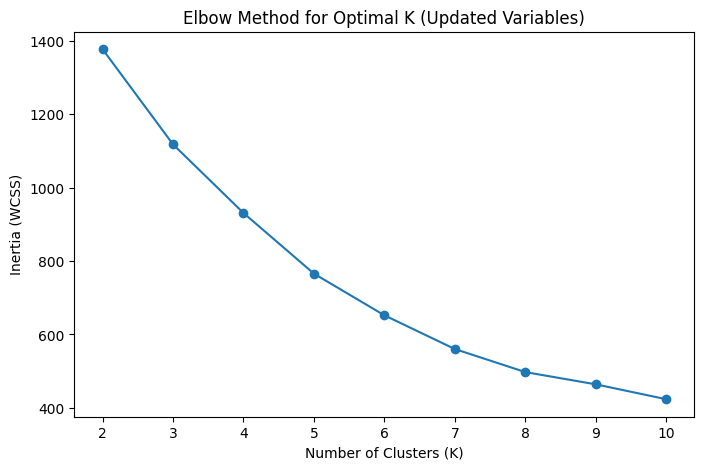

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)  # 2~10개의 군집 테스트

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

# Elbow Method 시각화
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K (Updated Variables)")
plt.show()

- Elbow Method플롯에서 inertia값이 급격히 감소하는 클러스터 3,4,5 선택 후 집중분석
- 군집갯수5 이후부턴 군집 증가 효과가 크지 않다.

### 실루엣계수 시각화 함수

In [44]:
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    import math

    n_clusters = len(cluster_lists)

    n_cols = min(n_clusters, 5)
    n_rows = math.ceil(n_clusters / n_cols)

    fig, axs = plt.subplots(figsize=(4 * n_cols, 4 * n_rows), nrows=n_rows, ncols=n_cols)

    axs = np.array(axs).reshape(-1) if n_clusters > 1 else [axs]

    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title(f'Number of Clusters: {n_cluster}\nSilhouette Score: {round(sil_avg, 3)}')
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

    for ax in axs[n_clusters:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### 군집 시각화 함수

In [45]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import math

    n_clusters = len(cluster_lists)
    n_cols = min(n_clusters, 5)
    n_rows = math.ceil(n_clusters / n_cols)

    fig, axs = plt.subplots(figsize=(4 * n_cols, 4 * n_rows), nrows=n_rows, ncols=n_cols)

    axs = np.array(axs).reshape(-1) if n_clusters > 1 else [axs]

    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1', 'PCA2'])

    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster'] = cluster_labels

        unique_labels = np.unique(cluster_labels)
        markers = ['o', 's', '^', 'x', '*', 'D', 'v', 'p', 'H', '+']

        for label in unique_labels:
            label_df = dataframe[dataframe['cluster'] == label]
            cluster_legend = f'Cluster {label}' if label != -1 else 'Noise'
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,
                             edgecolor='k', marker=markers[label % len(markers)], label=cluster_legend)

        axs[ind].set_title(f'Number of Clusters: {n_cluster}')
        axs[ind].legend(loc='upper right')

    for ax in axs[n_clusters:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

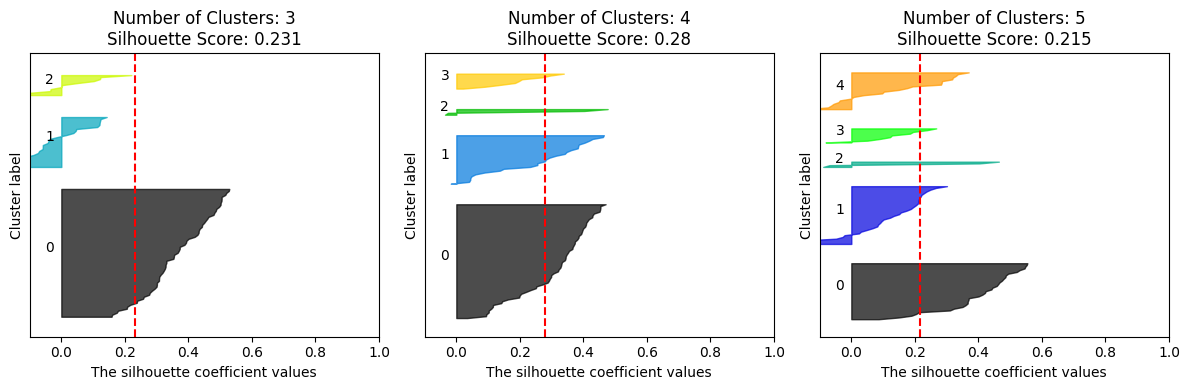

In [46]:
visualize_silhouette([3,4,5], df_pca)

C:\Users\tjdms\AppData\Local\Temp\ipykernel_24836\3892084.py:33: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,
C:\Users\tjdms\AppData\Local\Temp\ipykernel_24836\3892084.py:33: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,


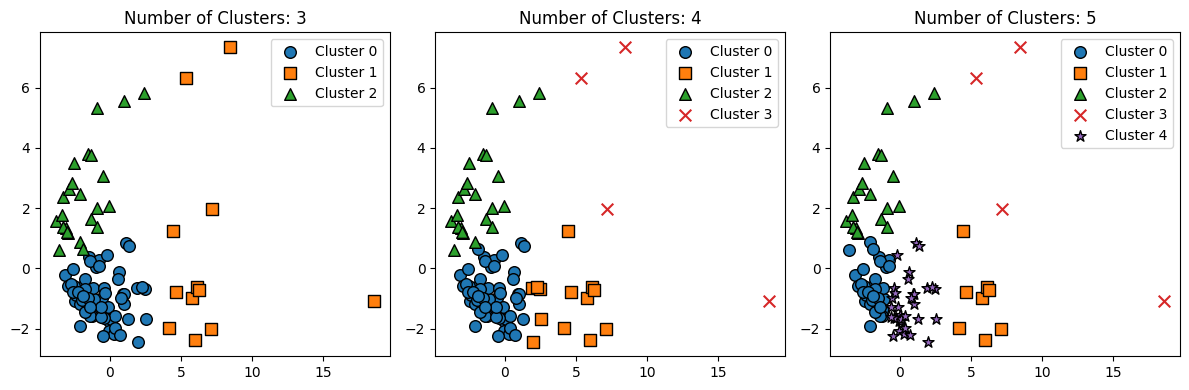

In [47]:
visualize_kmeans_plot_multi([3,4,5], df_pca)

### 군집수 결정: 4
- 4개의 군집에서 가장 군집화가 잘 이루어졌다.

In [48]:
# K-means 군집화 수행 (수정된 변수 적용)
kmeans_v2 = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster"] = kmeans_v2.fit_predict(df_pca)

# 군집별 데이터 요약 (수정된 변수 기준)
cluster_summary = df.groupby("Cluster")[selected_columns].mean()

# 각 클러스터에 속한 지역 확인
clustered_regions = df[["지역구", "지역시", "Cluster"]].sort_values(by="Cluster")

In [54]:
cluster_summary

,평균 숙박일수,장-단기 숙박비(-1 ~ 1),관광소비액(천원),쇼핑,숙박,음식,문화관광,역사관광,자연관광,체험관광,배우자,부모님,싱글,연인,자녀,친구,학생,회사동료,방문자수,체류시간,방문자 거리 평균,워케이션 언급량
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,2.611082,-0.019551,6.484666e+06,8580.230909,31401.634545,52325.234545,13751.874545,4501.791818,15376.373636,1100.231818,999.923636,2364.370909,984.160909,903.770909,1762.041818,2504.456364,457.381818,1662.106364,1.478114e+06,1492.940909,84.945431,40.179952
1,2.907105,-0.016700,1.792664e+07,36750.634266,10284.747902,89474.334615,23502.832517,3957.491259,3844.929720,778.816783,1555.755594,3326.293357,1749.588462,1389.661189,2812.924126,6529.051049,1083.095804,3546.156993,3.570544e+06,1118.573077,40.527592,8.093621
2,2.787273,-0.017489,1.386295e+08,97855.022727,119955.659091,398059.136364,125359.931818,10178.000000,1.318182,142.500000,16875.136364,38352.590909,17907.022727,15796.545455,22955.159091,11689.431818,2006.727273,49082.977273,1.761364e+07,594.068182,36.178813,77.659091
3,2.792831,-0.018016,5.863554e+07,81829.462810,69184.609504,174007.700413,68358.254132,7288.452479,26985.092975,2495.328512,5247.816116,11518.128099,6694.008264,5816.739669,8104.425620,15045.576446,1989.568182,14059.438017,8.451533e+06,1037.247934,64.437516,51.329402


In [50]:
# cluster_summary.to_csv('군집화 결과.csv')

In [ ]:
# clustered_regions.to_csv('클러스터별 지역.csv')


In [52]:
import pandas as pd
# # 열 , 행 , 데이터 출력제한 해제
pd.set_option('display.max_columns', None )
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


In [53]:
clustered_regions

,지역구,지역시,Cluster
0,가평군,경기도,0
33,부산중구,부산광역시,0
38,삼척시,강원특별자치도,0
100,화천군,강원특별자치도,0
63,양구군,강원특별자치도,0
64,양양군,강원특별자치도,0
67,양평군,경기도,0
70,연천군,경기도,0
71,영도구,부산광역시,0
30,동해시,강원특별자치도,0


## 군집 0
- **평균 숙박일수: 127.9일** → 4개 군집 중 **가장 긴 체류기간**
- **관광소비액: 약 7.88억 원** → 상대적으로 낮은 소비 규모
- **여행 목적: 자연관광, 체험관광 비율이 상대적으로 높음**
- **방문자 특성: 방문자 거리 평균이 1783km** → **장거리 여행자가 많음**
- **워케이션(Workation) 언급량: 275** → **다른 군집 대비 낮은 편**

해석:  
이 군집은 **장기 체류하면서 자연 및 체험 관광을 즐기는 방문자**가 많고,  
소비 수준이 높지 않으며, 워케이션(원격근무+여행) 관심도도 낮은 편.


## 군집 1
- **평균 숙박일수: 122.9일** → 평균보다 긴 체류기간
- **관광소비액: 약 25.8억 원** → 소비 규모가 상당히 큼
- **여행 목적: 음식, 쇼핑, 숙박이 높은 비율을 차지**
- **방문자 특성: 방문자 거리 평균이 2835km** → **가장 장거리 여행객이 많은 군집**
- **워케이션 언급량: 2195** → **워케이션 관심도 중간 수준**

해석:  
이 군집은 **소비력이 높은 방문객**이 많으며, **쇼핑과 미식 여행**을 주요 목적으로 삼음.  
장거리에서 오는 관광객 비율이 높으며, 체류 기간도 비교적 김


### 군집 2
- **평균 숙박일수: 114.9일** → 4개 군집 중 체류기간이 가장 짧음
- **관광소비액: 약 2.85억 원** → 소비 수준이 가장 낮음
- **여행 목적: 역사관광, 문화관광 비중이 상대적으로 높음**
- **방문자 특성: 방문자 거리 평균이 3737km** → 중장거리 방문자 많음
- **워케이션 언급량: 1662** → 중간 수준

해석:  
이 군집은 **역사·문화 관광을 선호하며, 비교적 짧은 기간 동안 여행하는 방문자**가 많음.  
소비액이 적고, 워케이션 관심도도 중간 정도.


### 군집 3
- **평균 숙박일수: 122.6일** → 체류기간이 중간 수준
- **관광소비액: 약 60.9억 원** → **가장 높은 소비 규모**
- **여행 목적: 음식, 쇼핑, 숙박이 압도적으로 높음**
- **방문자 특성: 방문자 거리 평균이 1591km** → 비교적 가까운 곳에서 방문
- **워케이션 언급량: 3417** → **워케이션 관심도가 가장 높음**

해석:  
이 군집은 **소비력이 가장 높은 방문객**이 많으며, **음식과 쇼핑 중심의 여행 패턴**을 보임.  
워케이션(업무와 여행을 병행하는 형태) 관심도가 가장 높아, 원격 근무 트렌드가 활성화된 지역일 가능성이 큼.


## 분석결과
- **군집 0** → 자연·체험 관광 중심, 장기 체류, 소비 적음  
- **군집 1** → 쇼핑·미식 여행 중심, 소비력 강함, 장거리 방문자 많음  
- **군집 2** → 역사·문화 관광 중심, 체류기간 짧음, 소비 적음  
- **군집 3** → **가장 높은 소비** (쇼핑+미식), 워케이션 중심, 중거리 방문자 많음  

**Cluster 0(저소비형)**
- 군집0 세부분석 :
    - 자연관광 소비가 가장 높은 그룹, 숙박과 음식 소비도 상대적으로 높음.
    - 전체적으로 동반자 유형이 균일하나, 자녀 동반이 상대적으로 많음.
    - 방문자 거리가 가장 길고, 체류시간이 가장 김. → 멀리서 오는 장기 체류형 방문객이 많을 가능성이 있음.
    
- 가족 및 단체 여행 마케팅
    - 자녀 동반 여행객이 많아 가족 맞춤형 콘텐츠 제공.
    숙박과 음식 소비가 많으므로 패밀리 패키지, 레스토랑 연계 상품 기획.   